<a href="https://colab.research.google.com/github/CalumGabbutt/IX-tutorial-CG-SBI/blob/main/IX_tutorial_CG_SBI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please run this install cell before we start, as they can take a while depending on download speeds. Because our networks are generally shallow and not-tall, we don't expect a speed up by running on a GPU, so you can keep the default runtime type as CPU.

In [1]:
!pip install sbi
!pip install corner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.1/383.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   

In [2]:
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import seaborn as sns
from scipy import stats
import corner
import os
import pickle

import torch
from torch.distributions import Beta, LogNormal, HalfNormal

from sbi.analysis import pairplot, conditional_potential
from sbi.inference import NPE, simulate_for_sbi, MCMCPosterior, posterior_estimator_based_potential
from sbi.utils import MultipleIndependent
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)


First, let's define the simulation functions to model how the distribution of fCpG methylation within a colonic crypt varies as a function of the replacement rate (lam), the epigenetic switching rates (mu, gamma) and the parameters determining the noise in the array (delta, eta, kappa).

Notice how the simulation mostly relies on numpy arrays and functions, rather than torch ones. This is a nice feature of the SBI package, in that the simulation function can be written however you like, even in another programming language like Julia or C++, as long as they store simulation outputs in a format that can be read from Python.

In [3]:
def initialise_stemcell_niche(S, N):
    """
    Initialises the stemcell niche as a clonal population of S stem cells
    at N fCpGs. The poopulation is assumed to be homozygous methylated or
    demethylated at t=0

    Arguments:
        S: Number of stem cells in the niche - int >= 1
        N: Number of fCpGs to consider - int >= 1
    Returns:
        stemcells: A 3D  numpy array representing the stemcell niche,
                    where the first index determines the cell, the second
                    index determines the DNA allele and the third index
                    determines the CpG site - np.array[:,:,:]
    """

    # Generate a random methylation pattern
    rng = np.random.default_rng()
    allele = rng.choice([True, False], size=N)

    # Create a 3D array representing the stemcell niche,
    dna = [copy.deepcopy(allele) for i in range(2)]
    dna = np.stack(dna)
    stemcells = np.stack([copy.deepcopy(dna) for i in range(S)])

    return stemcells

def select_adjacent_cells(S):
    """
    Randomly selects 2 adjacent cell indices, imposing periodic boundary
    conditions

    Arguments:
        S: Number of stem cells in the niche - int >= 1
    Returns:
        cells: Pair of randomly selected adjacent indices - tuple(int,int)
    """

    rng = np.random.default_rng()

    # Select the first cell at random, then pick an adjacent cell at random
    cell1 = rng.integers(S)
    cell2 = rng.choice([(cell1 - 1) % S, (cell1 + 1) % S])

    cells = (cell1, cell2)

    return cells

def methylation_sim(lam, mu, gamma, S, age, N):
    """
    Simulates the evolution of fCpG methylation in a well-mixed population of
    stem cells

    Arguments:
        lam: Replacement rate of one stem cell by another (/year) - float > 0
        mu: Methylation rate (/year/allele) - float >= 0
        gamma: Methylation rate (/year/allele) - float >= 0
        S: Number of stem cells in the niche - int >= 1
        age: Length of time to simulate the process for (years) - float > 0
        N: Number of fCpGs to consider - int >= 1
    Returns:
        stemcells: A binary 3D numpy array representing the stemcell niche,
                    where the first index determines the cell, the second
                    index determines the DNA strand and the third index
                    determines the CpG site - np.array[:,:,:]
    """

    # Intialise the stemcell niche
    stemcells = initialise_stemcell_niche(S, N)

    rng = np.random.default_rng()

    # Use a Gillepsie algorithm to model individual CpG changing methylation
    # status and the stem cells replacing each other
    t = 0
    counter = 0
    while t < age:
        # Draw the time until the next replacement event, assuming the
        # replacements are Poisson distributed
        twait = 1 / (lam * S) * np.log(1 / random.random())

        if t + twait < age:

            t += twait

            # Count the number of methylated/non-methylated sites
            num_on = np.count_nonzero(stemcells)
            num_off = 2*N*S - num_on

            # Create a copy of the stemcells array to act as a mask
            boolean_mask = copy.deepcopy(stemcells)

            # Calculate the probability that a site is methylated at time (t+twait),
            # given that the site was methylated at time t
            p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)

            # For each site methylated at time t, draw from a random distribution
            # with the above probability to see whether it is still methylated
            stemcells[boolean_mask] = rng.binomial(1, p_given_on, num_on)

            # Calculate the probability that a site is methylated at time (t+twait),
            # given that the site was not methylated at time t
            p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))

            # For each site unmethylated at time t, draw from a random distribution
            # with the above probability to see whether it is methylated
            stemcells[~boolean_mask] = rng.binomial(1, p_given_off, num_off)

            # Now that we have taken care of any mutations that have occured,
            # pick 2 cells at random, one to replace the other
            cells = select_adjacent_cells(S)
            stemcells[cells[0]] = copy.deepcopy(stemcells[cells[1]])

            counter += 1

        else:
            twait = age - t
            t += twait

            # Count the number of methylated/non-methylated sites
            num_on = np.count_nonzero(stemcells)
            num_off = 2*N*S - num_on

            # Create a copy of the stemcells array to act as a mask
            boolean_mask = copy.deepcopy(stemcells)

            # Calculate the probability that a site is methylated at time (t+twait),
            # given that the site was methylated at time t
            p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
            # For each site methylated at time t, draw from a random distribution
            # with the above probability to see whether it is still methylated
            stemcells[boolean_mask] = rng.binomial(1, p_given_on, num_on)

            # Calculate the probability that a site is methylated at time (t+twait),
            # given that the site was not methylated at time t
            p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))

            # For each site unmethylated at time t, draw from a random distribution
            # with the above probability to see whether it is methylated
            stemcells[~boolean_mask] = rng.binomial(1, p_given_off, num_off)

            break

    return stemcells

def beta_convert_params(mean, kappa):
    """
    Convert mean/dispersion parameterization of a beta distribution to the ones
    scipy supports

    Arguments:
        mean: Mean of the beta distribution - 0 < float < 1
        kappa: Precision of the beta distribution - float > 0

    Returns:
        a, b: Standard parameterisation of the beta distibution

    """

    if torch.any(kappa <= 0):
        raise Exception("kappa must be greater than 0")
    elif torch.any(mean <= 0) or torch.any(mean >= 1):
        raise Exception("mu must be between 0 and 1")

    a = kappa * mean
    b = kappa * (1- mean)

    return a, b

def beta_rvs(mean, kappa, **kwargs):
    """
    Convert mean/dispersion parameterization of a beta distribution to the ones
    scipy supports

    Arguments:
        mean: Mean of the beta distribution - 0 < float < 1
        kappa: Precision of the beta distribution - float > 0

    Returns:
        a, b: Standard parameterisation of the beta distibution
    """

    a, b = beta_convert_params(mean, kappa)

    return stats.beta.rvs(a, b, **kwargs)

def generate_data(S, lam, mu, gamma, delta, eta, kappa, age, N):

    stemcells = methylation_sim(lam, mu, gamma, S, age, N)

    mean_beta = np.mean(np.mean(stemcells, axis = 0), axis = 0)

    beta_obs = beta_rvs((eta - delta) * mean_beta + delta, kappa)

    return beta_obs

def lognormal_convert_params(mean, sigma):
    """
    Convert mean/std parameterization of a beta distribution to the ones
    scipy supports
    """

    if np.any(mean <= 0):
        raise Exception("mean must be greater than 0")
    elif np.any(sigma <= 0) :
        raise Exception("sigma must be greater than 0")

    log_mean = np.log(mean) - 0.5 * np.log1p(sigma**2 / mean**2)
    log_std = np.sqrt(np.log1p(sigma**2 / mean ** 2))

    return log_mean, log_std

Because the number of stem cells is a discrete parameter, we will have to be a bit careful about how we define constructing a density for it, so for our first pass, let's fix the number of stem cells, patient age and the number of fCpGs.

In [4]:
S = 5
N = 2000
age = 30

def prior_func():
    # Define independent prior for parameters [lam, mu, gamma,
    #            delta, eta, kappa]
    kappamean, kappastd = lognormal_convert_params(100, 30)

    prior = MultipleIndependent(
        [
            HalfNormal(torch.tensor([1.0])),
            HalfNormal(torch.tensor([0.05])),
            HalfNormal(torch.tensor([0.05])),
            Beta(torch.tensor([5.0]), torch.tensor([95.0])),
            Beta(torch.tensor([95.0]), torch.tensor([5.0])),
            LogNormal(torch.tensor([kappamean]), torch.tensor([kappastd])),
        ],
        validate_args=False,
    )

    return prior

def generate_data_wrapper(params):
    lam, mu, gamma, delta, eta, kappa = params
    return generate_data(S, lam, mu, gamma, delta, eta, kappa, age, N)

def calculate_summary_statistics(obs):
    hist, bin_edges = np.histogram(obs, np.linspace(0, 1, 101))
    return hist / np.sum(hist)

def simulation_wrapper(params):
    """
    Returns summary statistics from input paramaters in `params`.

    Summarizes the output of the simulator and converts it to `torch.Tensor`.
    """
    # print(params)
    obs = generate_data_wrapper(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))

    return summstats

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior_func())

# Check simulator, returns PyTorch simulator able to simulate batches.
simulation_wrapper = process_simulator(simulation_wrapper, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulation_wrapper, prior)

<ipython-input-3-58a952ae0c2f>:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
<ipython-input-3-58a952ae0c2f>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
<ipython-input-3-58a952ae0c2f>:129: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
<ipython-input-3-58a952ae0c2f>:136: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
<ipython-input-3-58a952

With our simulator defined, let's play around with the parameters and see how the distribution of fCpGs vary.

<ipython-input-3-58a952ae0c2f>:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
<ipython-input-3-58a952ae0c2f>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
<ipython-input-3-58a952ae0c2f>:129: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
<ipython-input-3-58a952ae0c2f>:136: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
<ipython-input-3-58a952

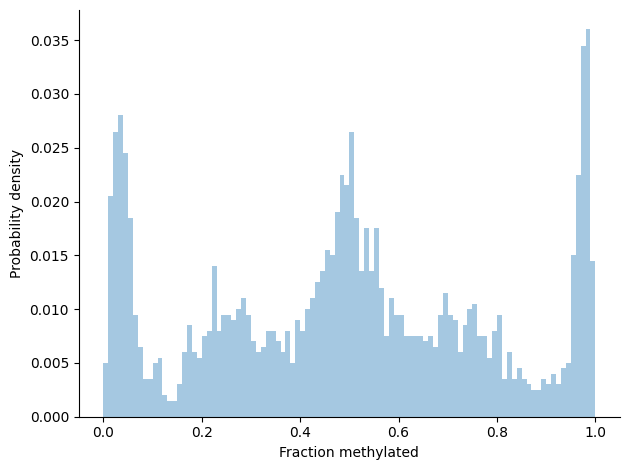

In [5]:
params_true = pd.Series({
    'lam' : 1.3,
    'mu' : 0.03,
    'gamma' : 0.03,
    'delta' : 0.04,
    'eta' : 0.97,
    'kappa' : 80,
})

# Let's generate and plot our "observed" data, y
y = simulation_wrapper(params_true.to_numpy().reshape(1, -1))
bins = np.linspace(0, 1, 101)
fig, ax = plt.subplots()
plt.bar(bins[:-1] + (bins[1:] - bins[:-1]) / 2, y[0, :],
        width=0.01, alpha = 0.4,
        )
plt.xlabel('Fraction methylated')
plt.ylabel('Probability density')
sns.despine()
plt.tight_layout()

Let's use the sbi simulate_for_sbi() function to generate a small test set of simulations and plot some of the samples.

In [ ]:
param_test, x_test = simulate_for_sbi(simulation_wrapper, proposal=prior,
                                      num_simulations=1000)
print("theta.shape", param_test.shape)
print("x.shape", x_test.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-4-a85c7bc02780>:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
<ipython-input-4-a85c7bc02780>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
<ipython-input-4-a85c7bc02780>:129: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
<ipython-input-4-a85c7bc02780>:136: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
<ipython-input-4-a85c7b

theta.shape torch.Size([1000, 6])
x.shape torch.Size([1000, 100])


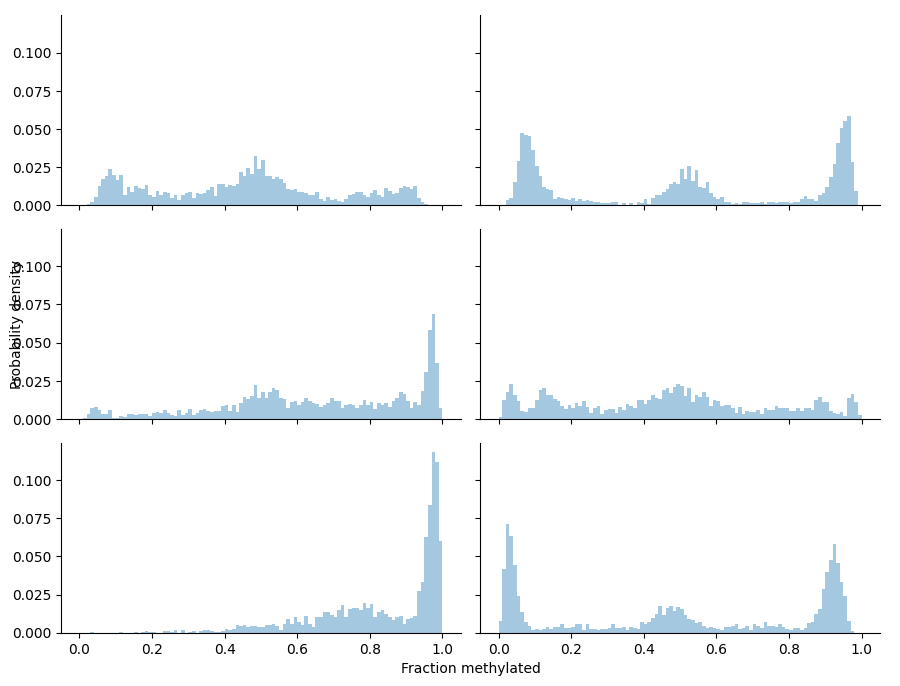

In [ ]:
bins = np.linspace(0, 1, 101)

fig, axes = plt.subplots(3, 2, sharex = True, sharey = True,
                         figsize = (9.6, 7.2))
for i, ax in enumerate(axes.flatten()):
    ax.bar(bins[:-1] + (bins[1:] - bins[:-1]) / 2, x_test[i, :],
        width=0.01, alpha = 0.4,
        )

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False,
                left=False, right=False)
plt.xlabel('Fraction methylated')
plt.ylabel('Probability density')

sns.despine()
plt.tight_layout()

Now we have a simulator with a set of simulated data, paired with the parameters used to generate those simulations. Let's feed those to the default Neural Posterior Estimation (NPE) method.

In [ ]:
inference = NPE(prior=prior)
inference.append_simulations(param_test, x_test)

In [ ]:
density_estimator = inference.train()
posterior = inference.build_posterior()

 Neural network successfully converged after 90 epochs.

We now have an amortised posterior object which will rapidly return samples from the posterior given any set of observed data. Let's pass it the observed data `y` above and examine the posterior.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

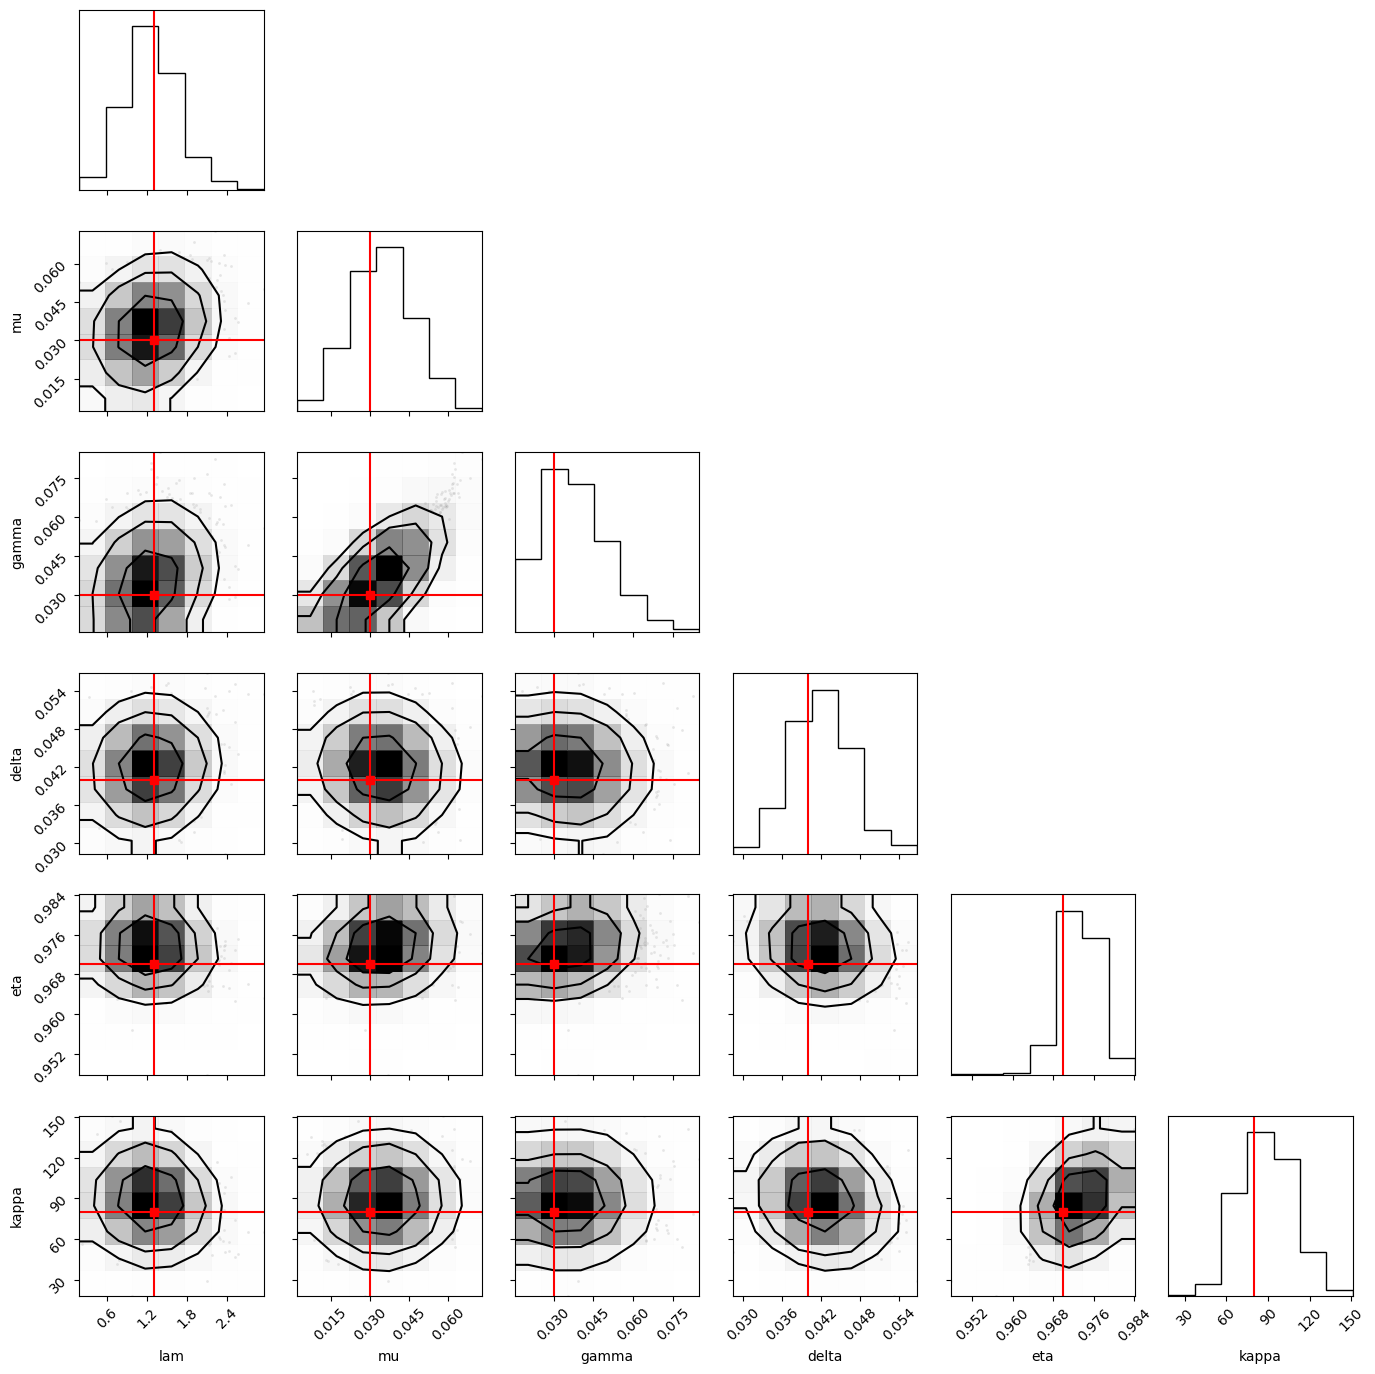

In [ ]:
posterior_samples = posterior.sample((1000,), x=y)
df = pd.DataFrame(posterior_samples, columns = params_true.index)

prior_samples = prior.sample((1000,))

# Visualise the univariate and pairwise marginals
figure = corner.corner(df.values, bins=7, smooth=1, labels=df.columns)
corner.overplot_lines(figure, params_true.values, color="r")
corner.overplot_points(figure, params_true.values[None], marker = 's',
                       color="r")
plt.tight_layout()

It's sometimes helpful to compare the univariate marginals of the posterior with the initial prior, to compare how much the model has learnt from the data.

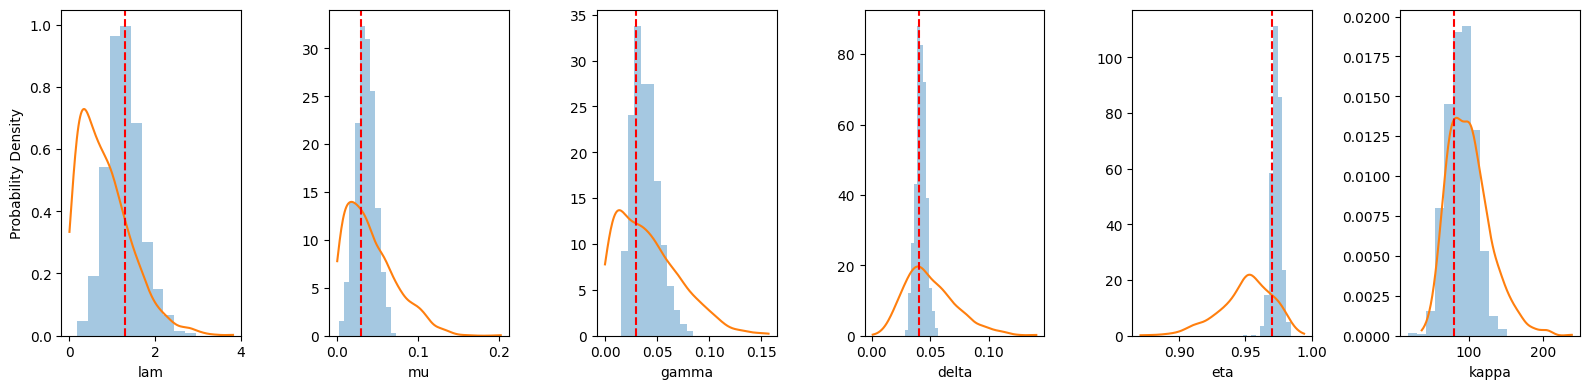

In [ ]:
ndims = df.shape[1]

fig, axes = plt.subplots(1, ndims, figsize = (16, 4))
for i, var in enumerate(df.columns):
    axes[i].hist(df.values[:, i], bins=11, alpha=0.4, density=True)
    sns.kdeplot(prior_samples[:, i], ax = axes[i], cut = 0)
    axes[i].axvline(x=params_true[var], linestyle = '--',
                    color = 'red')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('')
axes[0].set_ylabel('Probability Density')
plt.tight_layout()

It's also often useful to compare the observed data to simulations drawn from the posterior (often called the posterior predictive checks)

<ipython-input-4-a85c7bc02780>:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
<ipython-input-4-a85c7bc02780>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
<ipython-input-4-a85c7bc02780>:129: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
<ipython-input-4-a85c7bc02780>:136: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
<ipython-input-4-a85c7b

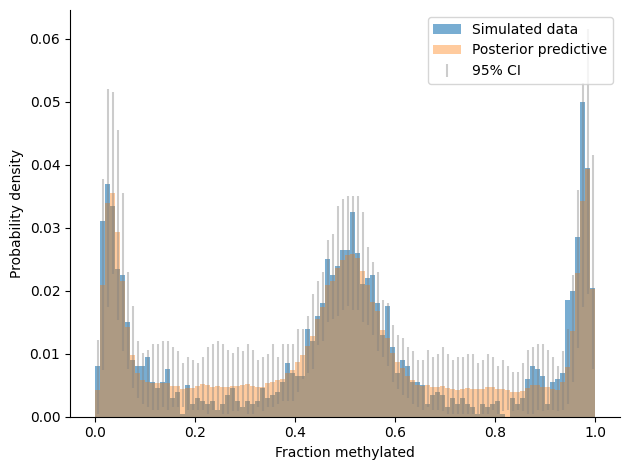

In [ ]:
# Let's generate simulations for the first 100 points in the posterior
y_hat = simulation_wrapper(posterior_samples[:100, :])
y_hat_mean = y_hat.mean(axis = 0)

# Calculate the posterior predictive mean and 95% CI
lower_err = y_hat.mean(axis = 0) - y_hat.quantile(0.025, axis = 0)
upper_err = y_hat.quantile(0.975, axis = 0) - y_hat.mean(axis = 0)
yhat_err = np.stack([lower_err, upper_err])

bin_centres = bins[:-1] + (bins[1:] - bins[:-1]) / 2

fig, ax = plt.subplots()
plt.bar(bin_centres, y[0, :], width=0.01, alpha = 0.6)
plt.bar(bin_centres, y_hat_mean, width=0.01, alpha = 0.4)
plt.errorbar(bin_centres, y_hat_mean, yerr = yhat_err, fmt = 'none',
             alpha = 0.4, color = 'gray')
plt.legend(['Simulated data', 'Posterior predictive', '95% CI'])
plt.xlabel('Fraction methylated')
plt.ylabel('Probability density')
sns.despine()
plt.tight_layout()

Those results are certainly encouraging, with just 1000 simulations the NN has been able to well identify some of the parameters, and identify a region of parameter space which produces simulations which "look like" the observed data. But how much of the parameter uncertainty is driven by a lack of simulations, rather than the inherent uncertainty in the posterior?

To save time, I've pregenerated a larger batch of simlulations (~100K) and trained a second NN on this data, which took about 2 hours on my MacBook. Let's see how good this network is compared to the one trained on a small batch of data.

In [8]:
!wget "https://github.com/CalumGabbutt/IX-tutorial-CG-SBI/raw/main/data/1-flipflop_inference.pkl"

--2025-03-26 16:52:23--  https://github.com/CalumGabbutt/IX-tutorial-CG-SBI/raw/main/data/1-flipflop_inference.pkl
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CalumGabbutt/IX-tutorial-CG-SBI/main/data/1-flipflop_inference.pkl [following]
--2025-03-26 16:52:23--  https://raw.githubusercontent.com/CalumGabbutt/IX-tutorial-CG-SBI/main/data/1-flipflop_inference.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50191451 (48M) [application/octet-stream]
Saving to: ‘1-flipflop_inference.pkl’

1-flipflop_inferenc 100%[===================>]  47.87M   139MB/s    in 0.3s    

2025-03-26 16:52:24 (139

In [11]:
with open("1-flipflop_inference.pkl", "rb") as f:
    posterior_big = pickle.load(f)

In [ ]:
posterior_samples_big = posterior_big.sample((1000,), x=y)
df_big = pd.DataFrame(posterior_samples_big, columns = params_true.index)

prior_samples = prior.sample((1000,))

# Visualise the univariate and pairwise marginals
figure = corner.corner(df_big.values, bins=7, smooth=1, labels=df.columns)
corner.overplot_lines(figure, params_true.values, color="r")
corner.overplot_points(figure, params_true.values[None], marker = 's',
                       color="r")
plt.tight_layout()